In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# 1. Load Data
# REPLACE with your actual file
df = pd.read_csv("fmcg_sales_3years_1M_rows.csv")

# 2. Date Conversion & Sorting (Critical for Lags)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['sku_id', 'date']).reset_index(drop=True)

print(f"Rows before filtering stockouts: {len(df)}")
df = df[df['stock_out_flag'] == 0] 
print(f"Rows after filtering stockouts: {len(df)}")

# 3. Basic Pricing
if 'effective_price' not in df.columns:
    df['effective_price'] = df['list_price'] * (1 - df['discount_pct'])

print(f"✅ Data Loaded. Shape: {df.shape}")

Rows before filtering stockouts: 1100000
Rows after filtering stockouts: 1066886
✅ Data Loaded. Shape: (1066886, 34)


In [60]:
import pandas as pd
import numpy as np

def engineer_features(df):
    """
    Optimized feature engineering pipeline (Vectorized).
    Compatible with prepare_data_for_modeling aggregation.
    """
    # Make a copy to avoid modifying original
    df = df.copy()
    
    # 0. BASIC DATE PARTS
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['store_id', 'sku_id', 'date']).reset_index(drop=True)
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    
    print("Starting feature engineering...")
    
    # ===================================
    # 1. TIME-BASED FEATURES
    # ===================================
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_month_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_of_month_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['quarter'] = df['date'].dt.quarter
    
    # ===================================
    # 2. LAG FEATURES & ROLLING STATS
    # ===================================
    grouper = df.groupby(['store_id', 'sku_id'])
    
    for lag in [1, 7, 14, 30]:
        df[f'units_sold_lag_{lag}'] = grouper['units_sold'].shift(lag)
        
    for window in [7, 14, 30]:
        df[f'rolling_avg_{window}d'] = grouper['units_sold'].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'rolling_std_{window}d'] = grouper['units_sold'].transform(lambda x: x.rolling(window, min_periods=1).std())

    df['rolling_max_7d'] = grouper['units_sold'].transform(lambda x: x.rolling(7, min_periods=1).max())
    df['rolling_min_7d'] = grouper['units_sold'].transform(lambda x: x.rolling(7, min_periods=1).min())

    # ===================================
    # 3. STOCK & RESTOCK (Restored Missing Columns)
    # ===================================
    df['stock_on_hand_lag_1'] = grouper['stock_on_hand'].shift(1)
    df['stock_change'] = df['stock_on_hand'] - df['stock_on_hand_lag_1']
    
    # FIXED: Added positive_stock_change
    df['positive_stock_change'] = df['stock_change'].clip(lower=0)
    
    # Use lag_1 we just created
    df['restock_flag'] = ((df['stock_change'] + df['units_sold_lag_1'].fillna(0)) > 10).astype(int)
    
    df['estimated_restock_amount'] = np.where(
        df['restock_flag'] == 1,
        df['stock_change'] + df['units_sold_lag_1'].fillna(0),
        0
    )

    # Days since restock (Vectorized)
    df['restock_date'] = np.where(df['restock_flag'] == 1, df['date'], pd.NaT)
    df['restock_date'] = pd.to_datetime(df['restock_date'])
    df['last_restock_date'] = grouper['restock_date'].ffill()
    df['days_since_restock'] = (df['date'] - df['last_restock_date']).dt.days.fillna(999)
    
    # FIXED: Added restock_frequency_7d (was missing)
    df['restock_frequency_7d'] = grouper['restock_flag'].transform(lambda x: x.rolling(7, min_periods=1).sum())
    df['restock_frequency_30d'] = grouper['restock_flag'].transform(lambda x: x.rolling(30, min_periods=1).sum())
    
    # FIXED: Added avg_restock_amount_30d
    df['avg_restock_amount_30d'] = grouper['estimated_restock_amount'].transform(lambda x: x.rolling(30, min_periods=1).mean())
    
    # ===================================
    # 4. PROMOTION FEATURES
    # ===================================
    df['discount_amount'] = df['list_price'] * (df['discount_pct']) 
    
    # Days since promo (Vectorized)
    df['promo_date_temp'] = np.where(df['promo_flag'] == 1, df['date'], pd.NaT)
    df['promo_date_temp'] = pd.to_datetime(df['promo_date_temp'])
    df['last_promo_date'] = grouper['promo_date_temp'].ffill()
    df['days_since_promo'] = (df['date'] - df['last_promo_date']).dt.days.fillna(999)
    
    df['promo_frequency_30d'] = grouper['promo_flag'].transform(lambda x: x.rolling(30, min_periods=1).sum())
    
    # FIXED: Added avg_discount_when_promo_30d
    # We calculate rolling mean of discount_pct ONLY where promo_flag is 1
    df['avg_discount_when_promo_30d'] = grouper.apply(
        lambda x: x['discount_pct'].where(x['promo_flag'] == 1).rolling(30, min_periods=1).mean()
    ).reset_index(level=[0,1], drop=True)

    # ===================================
    # 5. INVENTORY & PROFIT (Restored Missing Columns)
    # ===================================
    safe_rolling_avg = df['rolling_avg_7d'].replace(0, 0.1)
    df['days_of_stock_remaining'] = df['stock_on_hand'] / safe_rolling_avg
    
    # FIXED: Added stock_to_sales_ratio
    df['stock_to_sales_ratio'] = df['stock_on_hand'] / df['units_sold'].replace(0, 1)

    if 'lead_time_days' in df.columns:
        df['safety_stock_level'] = df['rolling_avg_7d'] * df['lead_time_days']
    else:
        df['safety_stock_level'] = df['rolling_avg_7d'] * 7 
        
    # FIXED: Added above_safety_stock
    df['above_safety_stock'] = (df['stock_on_hand'] > df['safety_stock_level']).astype(int)
    
    # FIXED: Added stockout_risk and avg_days_between_restocks
    df['avg_days_between_restocks'] = 30 / df['restock_frequency_30d'].replace(0, 30)
    df['stockout_risk'] = (df['days_of_stock_remaining'] < df['avg_days_between_restocks']).astype(int)
    
    df['profit_per_unit'] = df['list_price'] * (1 - df['discount_pct']) - df['purchase_cost']
    df['total_daily_profit'] = df['units_sold'] * df['profit_per_unit']
    
    # FIXED: Added rolling profit metrics
    df['rolling_profit_7d'] = grouper['total_daily_profit'].transform(lambda x: x.rolling(7, min_periods=1).sum())
    df['rolling_profit_30d'] = grouper['total_daily_profit'].transform(lambda x: x.rolling(30, min_periods=1).sum())
    
    # FIXED: Added cost_volatility_30d
    df['cost_volatility_30d'] = grouper['purchase_cost'].transform(lambda x: x.rolling(30, min_periods=1).std())
    
    # ===================================
    # 6. WEATHER
    # ===================================
    if 'temperature' in df.columns:
        df['temp_cold'] = (df['temperature'] < 10).astype(int)
        df['temp_mild'] = ((df['temperature'] >= 10) & (df['temperature'] < 20)).astype(int)
        df['temp_warm'] = (df['temperature'] >= 20).astype(int)
    else:
        # Fallback if weather columns missing
        df['temperature'] = 0
        df['temp_cold'] = 0
        df['temp_mild'] = 0
        df['temp_warm'] = 0

    if 'rain_mm' in df.columns:
        df['is_raining'] = (df['rain_mm'] > 0).astype(int)
        # FIXED: Added heavy_rain
        df['heavy_rain'] = (df['rain_mm'] > 5).astype(int)
    else:
        df['rain_mm'] = 0
        df['is_raining'] = 0
        df['heavy_rain'] = 0
    
    # ===================================
    # CLEANUP
    # ===================================
    lag_cols = [c for c in df.columns if 'lag' in c or 'rolling' in c]
    df[lag_cols] = df[lag_cols].fillna(0)
    
    # Drop temp columns
    drop_cols = ['restock_date', 'last_restock_date', 'promo_date_temp', 
                 'last_promo_date', 'stock_on_hand_lag_1']
    # NOTE: We DO NOT drop 'units_sold_lag_1' because prepare_data uses it
    
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
    
    print(f"✅ Feature Engineering Complete. New Shape: {df.shape}")
    return df

In [61]:
df_eng = engineer_features(df)

Starting feature engineering...
✅ Feature Engineering Complete. New Shape: (1100000, 80)


In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta

def prepare_data_for_modeling(df_engineered, test_size_days=30, val_size_days=30):
    """
    Prepare engineered data for baseline and promotion modeling
    
    Parameters:
    -----------
    df_engineered : DataFrame
        Output from engineer_features() function
    test_size_days : int
        Number of days to use for test set (most recent data)
    val_size_days : int
        Number of days to use for validation set
    
    Returns:
    --------
    dict containing all prepared datasets and encoders
    """
    
    df = df_engineered.copy()
    print("="*70)
    print("DATA PREPARATION FOR MODELING")
    print("="*70)
    print(f"\nInitial data shape: {df.shape}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Total days: {(df['date'].max() - df['date'].min()).days}")
    print(f"Number of stores: {df['store_id'].nunique()}")
    print(f"Number of SKUs: {df['sku_id'].nunique()}")
    
    # ===================================
    # 1. AGGREGATE BY DATE (Not by Store)
    # ===================================
    print("\n" + "-"*70)
    print("STEP 1: Aggregating across stores (daily total)")
    print("-"*70)
    
    # Define aggregation functions for each column
    agg_dict = {
        # Identifiers (take first/mode)
        'year': 'first',
        'month': 'first',
        'day': 'first',
        'weekofyear': 'first',
        'weekday': 'first',
        'is_weekend': 'first',
        'is_holiday': 'first',
        
        # Weather (average across stores)
        'temperature': 'mean',
        'rain_mm': 'mean',
        
        # SKU info (take first - should be same across stores)
        'sku_name': 'first',
        'category': 'first',
        'subcategory': 'first',
        'brand': 'first',
        
        # Sales metrics (SUM across stores)
        'units_sold': 'sum',
        'gross_sales': 'sum',
        'net_sales': 'sum',
        
        # Price/discount (average - should be similar)
        'list_price': 'mean',
        'discount_pct': 'mean',
        'promo_flag': 'max',  # 1 if ANY store had promo
        
        # Stock (SUM across stores)
        'stock_on_hand': 'sum',
        'stock_out_flag': 'max',  # 1 if ANY store had stockout
        
        # Supply chain (average)
        'lead_time_days': 'mean',
        'purchase_cost': 'mean',
        'margin_pct': 'mean',
        
        # Engineered features - Time (first)
        'day_of_week_sin': 'first',
        'day_of_week_cos': 'first',
        'month_sin': 'first',
        'month_cos': 'first',
        'day_of_month_sin': 'first',
        'day_of_month_cos': 'first',
        'quarter': 'first',
        
        # Engineered features - Lags (sum across stores)
        'units_sold_lag_1': 'sum',
        'units_sold_lag_7': 'sum',
        'units_sold_lag_14': 'sum',
        'units_sold_lag_30': 'sum',
        
        # Engineered features - Rolling stats (sum for totals, mean for rates)
        'rolling_avg_7d': 'sum',
        'rolling_avg_14d': 'sum',
        'rolling_avg_30d': 'sum',
        'rolling_std_7d': 'mean',
        'rolling_std_14d': 'mean',
        'rolling_std_30d': 'mean',
        'rolling_max_7d': 'sum',
        'rolling_min_7d': 'sum',
        
        # Stock features (sum across stores)
        'stock_change': 'sum',
        'positive_stock_change': 'sum',
        'restock_flag': 'max',
        'estimated_restock_amount': 'sum',
        'days_since_restock': 'mean',
        'restock_frequency_7d': 'sum',
        'restock_frequency_30d': 'sum',
        'avg_restock_amount_30d': 'mean',
        
        # Inventory adequacy (average across stores)
        'days_of_stock_remaining': 'mean',
        'stock_to_sales_ratio': 'mean',
        'safety_stock_level': 'sum',
        'above_safety_stock': 'mean',
        'avg_days_between_restocks': 'mean',
        'stockout_risk': 'max',
        
        # Profitability (sum for totals, mean for rates)
        'profit_per_unit': 'mean',
        'total_daily_profit': 'sum',
        'rolling_profit_7d': 'sum',
        'rolling_profit_30d': 'sum',
        'cost_volatility_30d': 'mean',
        
        # Promotion features
        'discount_amount': 'mean',
        'days_since_promo': 'mean',
        'promo_frequency_30d': 'sum',
        'avg_discount_when_promo_30d': 'mean',
        
        # Weather interactions
        'temp_cold': 'max',
        'temp_mild': 'max',
        'temp_warm': 'max',
        'is_raining': 'max',
        'heavy_rain': 'max',
    }
    
    # Aggregate by date and SKU
    df_agg = df.groupby(['date', 'sku_id']).agg(agg_dict).reset_index()
    
    print(f"After aggregation shape: {df_agg.shape}")
    print(f"Stores aggregated: ✓")
    
    # ===================================
    # 2. HANDLE CATEGORICAL ENCODING
    # ===================================
    print("\n" + "-"*70)
    print("STEP 2: Encoding categorical variables")
    print("-"*70)
    
    # Categorical columns to encode
    categorical_cols = ['sku_id', 'category', 'subcategory', 'brand', 'sku_name']
    
    # Create label encoders
    encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_agg[f'{col}_encoded'] = le.fit_transform(df_agg[col].astype(str))
        encoders[col] = le
        print(f"  {col}: {df_agg[col].nunique()} unique values encoded")
    
    # ===================================
    # 3. TIME-BASED SPLIT
    # ===================================
    print("\n" + "-"*70)
    print("STEP 3: Time-based train/val/test split")
    print("-"*70)
    
    # Get date boundaries
    max_date = df_agg['date'].max()
    test_start_date = max_date - timedelta(days=test_size_days)
    val_start_date = test_start_date - timedelta(days=val_size_days)
    
    print(f"\nSplit dates:")
    print(f"  Training:   {df_agg['date'].min()} to {val_start_date - timedelta(days=1)}")
    print(f"  Validation: {val_start_date} to {test_start_date - timedelta(days=1)}")
    print(f"  Test:       {test_start_date} to {max_date}")
    
    # Create splits
    train_data = df_agg[df_agg['date'] < val_start_date].copy()
    val_data = df_agg[(df_agg['date'] >= val_start_date) & (df_agg['date'] < test_start_date)].copy()
    test_data = df_agg[df_agg['date'] >= test_start_date].copy()
    
    print(f"\nSplit sizes:")
    print(f"  Train: {len(train_data)} rows ({len(train_data)/len(df_agg)*100:.1f}%)")
    print(f"  Val:   {len(val_data)} rows ({len(val_data)/len(df_agg)*100:.1f}%)")
    print(f"  Test:  {len(test_data)} rows ({len(test_data)/len(df_agg)*100:.1f}%)")
    
    # ===================================
    # 4. SPLIT INTO BASELINE vs PROMOTION DATA
    # ===================================
    print("\n" + "-"*70)
    print("STEP 4: Separating baseline (no promo) vs promotion data")
    print("-"*70)
    
    # BASELINE DATA: Only non-promotional periods (promo_flag = 0)
    baseline_train = train_data[train_data['promo_flag'] == 0].copy()
    baseline_val = val_data[val_data['promo_flag'] == 0].copy()
    baseline_test = test_data[test_data['promo_flag'] == 0].copy()
    
    # PROMOTION DATA: ALL data (both promo and non-promo)
    promo_train = train_data.copy()
    promo_val = val_data.copy()
    promo_test = test_data.copy()
    
    print(f"\nBaseline model data (promo_flag = 0 only):")
    print(f"  Train: {len(baseline_train)} rows")
    print(f"  Val:   {len(baseline_val)} rows")
    print(f"  Test:  {len(baseline_test)} rows")
    
    print(f"\nPromotion model data (all data):")
    print(f"  Train: {len(promo_train)} rows ({promo_train['promo_flag'].sum()} with promos)")
    print(f"  Val:   {len(promo_val)} rows ({promo_val['promo_flag'].sum()} with promos)")
    print(f"  Test:  {len(promo_test)} rows ({promo_test['promo_flag'].sum()} with promos)")
    
    # Check promotion ratio
    promo_ratio = promo_train['promo_flag'].mean()
    print(f"\nPromotion ratio in training data: {promo_ratio*100:.1f}%")
    if promo_ratio < 0.05:
        print("  ⚠️  WARNING: Very few promotional periods in data (<5%)")
        print("  Consider using industry benchmarks or elasticity estimates")
    
    # ===================================
    # 5. DEFINE FEATURE COLUMNS
    # ===================================
    print("\n" + "-"*70)
    print("STEP 5: Defining feature sets")
    print("-"*70)
    
    # Columns to exclude from features (identifiers, targets, raw categoricals)
    exclude_cols = [
        'date', 'year', 'month', 'day',  # Keep weekday, is_weekend, etc.
        'sku_id', 'sku_name', 'category', 'subcategory', 'brand',  # Use encoded versions
        'units_sold',  # This is our target
        'gross_sales', 'net_sales',  # Derived from target
        'total_daily_profit',  # Derived from target
        # --- ADD THESE TO PREVENT LEAKAGE ---
        'stock_out_flag',     # We want unconstrained demand
        'stock_change',       # This reveals sales info
        'days_of_stock_remaining'
    ]
    
    # BASELINE FEATURES: Exclude promotion-related features
    baseline_exclude = exclude_cols + [
        'promo_flag', 'discount_pct', 'discount_amount',
        'days_since_promo', 'promo_frequency_30d', 'avg_discount_when_promo_30d'
    ]
    
    baseline_features = [col for col in baseline_train.columns 
                        if col not in baseline_exclude]
    
    # PROMOTION FEATURES: Include all features including promotion ones
    promo_features = [col for col in promo_train.columns 
                     if col not in exclude_cols]
    
    print(f"\nBaseline model features: {len(baseline_features)} features")
    print(f"  (excludes promotion-related features)")
    
    print(f"\nPromotion model features: {len(promo_features)} features")
    print(f"  (includes promotion features: discount_pct, promo_flag, etc.)")
    
    # ===================================
    # 6. CREATE FINAL DATASETS
    # ===================================
    print("\n" + "-"*70)
    print("STEP 6: Creating final X and y datasets")
    print("-"*70)
    
    # Target variable
    target = 'units_sold'
    
    # BASELINE MODEL DATASETS
    X_baseline_train = baseline_train[baseline_features]
    y_baseline_train = baseline_train[target]
    
    X_baseline_val = baseline_val[baseline_features]
    y_baseline_val = baseline_val[target]
    
    X_baseline_test = baseline_test[baseline_features]
    y_baseline_test = baseline_test[target]
    
    # PROMOTION MODEL DATASETS
    X_promo_train = promo_train[promo_features]
    y_promo_train = promo_train[target]
    
    X_promo_val = promo_val[promo_features]
    y_promo_val = promo_val[target]
    
    X_promo_test = promo_test[promo_features]
    y_promo_test = promo_test[target]
    
    print("\n✓ Datasets created successfully!")
    
    # ===================================
    # 7. INDUSTRY BENCHMARK ELASTICITY
    # ===================================
    print("\n" + "-"*70)
    print("STEP 7: Industry benchmark elasticity (fallback)")
    print("-"*70)
    
    # If not enough promo data, use industry benchmarks
    # Price elasticity typically ranges from -1.5 to -3.0 for consumer goods
    # Meaning: 10% discount → 15-30% increase in sales
    
    industry_elasticity = {
        'Personal Care': -2.0,   # 10% discount → 20% sales increase
        'Food': -1.5,            # 10% discount → 15% sales increase
        'Beverages': -2.5,       # 10% discount → 25% sales increase
        'Household': -1.8,       # 10% discount → 18% sales increase
        'Default': -2.0          # Default assumption
    }
    
    print("\nIndustry elasticity benchmarks:")
    for category, elasticity in industry_elasticity.items():
        print(f"  {category}: {elasticity}")
        print(f"    → 10% discount = {abs(elasticity)*10:.0f}% sales increase")
        print(f"    → 20% discount = {abs(elasticity)*20:.0f}% sales increase")
    
    # ===================================
    # 8. PREPARE RETURN PACKAGE
    # ===================================
    
    data_package = {
        # Aggregated full data
        'df_aggregated': df_agg,
        
        # Baseline model data
        'baseline': {
            'X_train': X_baseline_train,
            'y_train': y_baseline_train,
            'X_val': X_baseline_val,
            'y_val': y_baseline_val,
            'X_test': X_baseline_test,
            'y_test': y_baseline_test,
            'features': baseline_features,
            'train_data': baseline_train,
            'val_data': baseline_val,
            'test_data': baseline_test,
        },
        
        # Promotion model data
        'promotion': {
            'X_train': X_promo_train,
            'y_train': y_promo_train,
            'X_val': X_promo_val,
            'y_val': y_promo_val,
            'X_test': X_promo_test,
            'y_test': y_promo_test,
            'features': promo_features,
            'train_data': promo_train,
            'val_data': promo_val,
            'test_data': promo_test,
        },
        
        # Encoders
        'encoders': encoders,
        
        # Industry benchmarks
        'industry_elasticity': industry_elasticity,
        
        # Metadata
        'metadata': {
            'target': target,
            'test_start_date': test_start_date,
            'val_start_date': val_start_date,
            'max_date': max_date,
            'n_stores_aggregated': df['store_id'].nunique(),
            'n_skus': df_agg['sku_id'].nunique(),
            'promo_ratio': promo_ratio,
        }
    }
    
    print("\n" + "="*70)
    print("DATA PREPARATION COMPLETE!")
    print("="*70)
    print("\nAccess data using:")
    print("  data['baseline']['X_train']  - Baseline model training features")
    print("  data['baseline']['y_train']  - Baseline model training target")
    print("  data['promotion']['X_train'] - Promotion model training features")
    print("  data['promotion']['y_train'] - Promotion model training target")
    print("  data['encoders']             - Label encoders for categorical vars")
    print("  data['industry_elasticity']  - Fallback elasticity benchmarks")
    print("  data['metadata']             - Dataset metadata")
    
    return data_package


# ===================================
# HELPER FUNCTION: Apply Industry Elasticity
# ===================================
def apply_industry_elasticity(baseline_forecast, discount_pct, category='Default', 
                               elasticity_dict=None):
    """
    Apply industry elasticity benchmark to baseline forecast
    
    Parameters:
    -----------
    baseline_forecast : float or array
        Predicted units sold without promotion
    discount_pct : float
        Discount percentage (0.0 to 1.0, e.g., 0.10 for 10%)
    category : str
        Product category for elasticity lookup
    elasticity_dict : dict
        Custom elasticity values by category
    
    Returns:
    --------
    promo_forecast : Predicted units sold with promotion
    lift_pct : Percentage increase in sales
    """
    
    if elasticity_dict is None:
        elasticity_dict = {
            'Personal Care': -2.0,
            'Food': -1.5,
            'Beverages': -2.5,
            'Household': -1.8,
            'Default': -2.0
        }
    
    # Get elasticity for category
    elasticity = elasticity_dict.get(category, elasticity_dict['Default'])
    
    # Calculate lift: elasticity * discount_pct
    # e.g., elasticity=-2.0, discount=0.10 → lift = 0.20 (20% increase)
    lift_pct = abs(elasticity) * discount_pct
    
    # Apply lift to baseline
    promo_forecast = baseline_forecast * (1 + lift_pct)
    
    return promo_forecast, lift_pct


# ===================================
# USAGE EXAMPLE
# ===================================
if __name__ == "__main__":
    
    print("\n" + "="*70)
    print("EXAMPLE USAGE")
    print("="*70)
    
    data = prepare_data_for_modeling(df_eng, test_size_days=30, val_size_days=30)
    
    # Example: Using industry elasticity as fallback
    print("\n" + "-"*70)
    print("Example: Industry Elasticity Fallback")
    print("-"*70)
    
    baseline_sales = 100  # units
    discount = 0.20  # 20% discount
    category = 'Personal Care'
    
    promo_sales, lift = apply_industry_elasticity(
        baseline_sales, 
        discount, 
        category
    )
    
    print(f"\nBaseline forecast: {baseline_sales} units")
    print(f"Discount: {discount*100:.0f}%")
    print(f"Category: {category}")
    print(f"Expected lift: {lift*100:.0f}%")
    print(f"Promotion forecast: {promo_sales:.0f} units")
    print(f"Incremental units: {promo_sales - baseline_sales:.0f}")


EXAMPLE USAGE
DATA PREPARATION FOR MODELING

Initial data shape: (1100000, 80)
Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00
Total days: 1094
Number of stores: 13
Number of SKUs: 102

----------------------------------------------------------------------
STEP 1: Aggregating across stores (daily total)
----------------------------------------------------------------------
After aggregation shape: (111690, 73)
Stores aggregated: ✓

----------------------------------------------------------------------
STEP 2: Encoding categorical variables
----------------------------------------------------------------------
  sku_id: 102 unique values encoded
  category: 5 unique values encoded
  subcategory: 17 unique values encoded
  brand: 6 unique values encoded
  sku_name: 102 unique values encoded

----------------------------------------------------------------------
STEP 3: Time-based train/val/test split
----------------------------------------------------------------------

Split da


EXAMPLE USAGE
TRAINING BASELINE DEMAND MODEL
Model type: lightgbm
Training samples: 96966
Validation samples: 2830
Features: 56

----------------------------------------------------------------------
BASELINE MODEL PERFORMANCE
----------------------------------------------------------------------

TRAIN:
  MAE:  28.00 units
  RMSE: 40.00 units
  R²:   0.9855
  MAPE: 5.74%

VAL:
  MAE:  31.86 units
  RMSE: 48.34 units
  R²:   0.9793
  MAPE: 6.19%

TEST:
  MAE:  34.21 units
  RMSE: 54.39 units
  R²:   0.9793
  MAPE: 6.15%

TRAINING PROMOTION DEMAND MODEL
Model type: lightgbm
Training samples: 105468
  - With promotions: 8502
  - Without promotions: 96966
Validation samples: 3060
Features: 62

----------------------------------------------------------------------
PROMOTION MODEL PERFORMANCE
----------------------------------------------------------------------

TRAIN:
  MAE:  30.06 units
  RMSE: 43.56 units
  R²:   0.9874
  MAPE: 5.80%

VAL:
  MAE:  34.48 units
  RMSE: 53.64 units
  R²: 

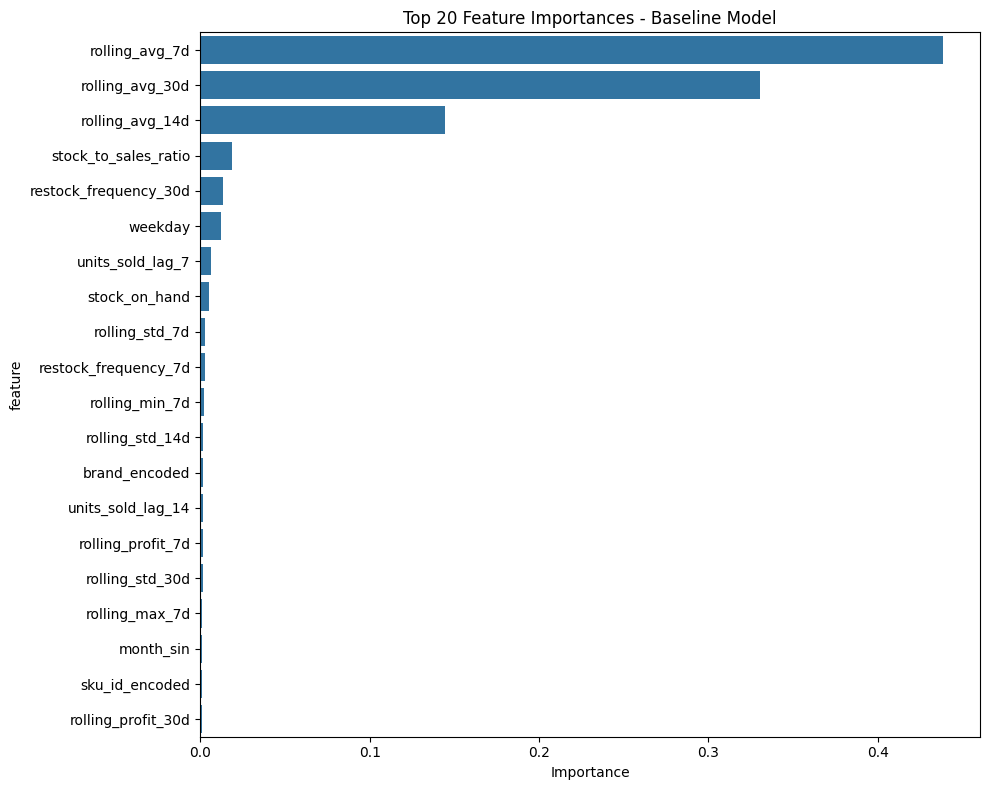

In [65]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ===================================
# MODEL TRAINING PIPELINE
# ===================================

def train_baseline_model(data, model_type='lightgbm', tune_hyperparams=False):
    """
    Train baseline demand model (no promotions)
    
    Parameters:
    -----------
    data : dict
        Output from prepare_data_for_modeling()
    model_type : str
        'lightgbm', 'xgboost', 'random_forest', or 'gradient_boosting'
    tune_hyperparams : bool
        Whether to perform hyperparameter tuning (takes longer)
    
    Returns:
    --------
    model : trained model
    metrics : dict of evaluation metrics
    """
    
    print("="*70)
    print("TRAINING BASELINE DEMAND MODEL")
    print("="*70)
    print(f"Model type: {model_type}")
    print(f"Training samples: {len(data['baseline']['X_train'])}")
    print(f"Validation samples: {len(data['baseline']['X_val'])}")
    print(f"Features: {len(data['baseline']['features'])}")
    
    # Get data
    X_train = data['baseline']['X_train']
    y_train = data['baseline']['y_train']
    X_val = data['baseline']['X_val']
    y_val = data['baseline']['y_val']
    X_test = data['baseline']['X_test']
    y_test = data['baseline']['y_test']
    
    # Handle any remaining NaN or inf values
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Initialize model
    if model_type == 'lightgbm':
        if tune_hyperparams:
            params = {
                'objective': 'regression',
                'metric': 'mae',
                'num_leaves': 64,
                'learning_rate': 0.05,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': -1,
                'n_estimators': 500,
                'early_stopping_rounds': 50
            }
        else:
            params = {
                'objective': 'regression',
                'metric': 'mae',
                'num_leaves': 31,
                'learning_rate': 0.1,
                'verbose': -1,
                'n_estimators': 200
            }
        
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='mae',
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )
        
    elif model_type == 'xgboost':
        if tune_hyperparams:
            params = {
                'objective': 'reg:squarederror',
                'max_depth': 8,
                'learning_rate': 0.05,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'n_estimators': 500,
                'early_stopping_rounds': 50
            }
        else:
            params = {
                'objective': 'reg:squarederror',
                'max_depth': 6,
                'learning_rate': 0.1,
                'n_estimators': 200
            }
        
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
    elif model_type == 'random_forest':
        params = {
            'n_estimators': 200 if not tune_hyperparams else 500,
            'max_depth': 20 if not tune_hyperparams else 30,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'random_state': 42,
            'n_jobs': -1
        }
        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        
    elif model_type == 'gradient_boosting':
        params = {
            'n_estimators': 200 if not tune_hyperparams else 500,
            'learning_rate': 0.1 if not tune_hyperparams else 0.05,
            'max_depth': 5,
            'random_state': 42
        }
        model = GradientBoostingRegressor(**params)
        model.fit(X_train, y_train)
    
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Ensure non-negative predictions
    y_train_pred = np.maximum(y_train_pred, 0)
    y_val_pred = np.maximum(y_val_pred, 0)
    y_test_pred = np.maximum(y_test_pred, 0)
    
    # Calculate metrics
    metrics = {
        'train': {
            'mae': mean_absolute_error(y_train, y_train_pred),
            'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'r2': r2_score(y_train, y_train_pred),
            'mape': np.mean(np.abs((y_train - y_train_pred) / (y_train + 1))) * 100
        },
        'val': {
            'mae': mean_absolute_error(y_val, y_val_pred),
            'rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
            'r2': r2_score(y_val, y_val_pred),
            'mape': np.mean(np.abs((y_val - y_val_pred) / (y_val + 1))) * 100
        },
        'test': {
            'mae': mean_absolute_error(y_test, y_test_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'r2': r2_score(y_test, y_test_pred),
            'mape': np.mean(np.abs((y_test - y_test_pred) / (y_test + 1))) * 100
        }
    }
    
    # Print results
    print("\n" + "-"*70)
    print("BASELINE MODEL PERFORMANCE")
    print("-"*70)
    for split in ['train', 'val', 'test']:
        print(f"\n{split.upper()}:")
        print(f"  MAE:  {metrics[split]['mae']:.2f} units")
        print(f"  RMSE: {metrics[split]['rmse']:.2f} units")
        print(f"  R²:   {metrics[split]['r2']:.4f}")
        print(f"  MAPE: {metrics[split]['mape']:.2f}%")
    
    return model, metrics


def train_promotion_model(data, model_type='lightgbm', tune_hyperparams=False):
    """
    Train promotion demand model (with promotion features)
    
    Parameters:
    -----------
    data : dict
        Output from prepare_data_for_modeling()
    model_type : str
        'lightgbm', 'xgboost', 'random_forest', or 'gradient_boosting'
    tune_hyperparams : bool
        Whether to perform hyperparameter tuning
    
    Returns:
    --------
    model : trained model
    metrics : dict of evaluation metrics
    """
    
    print("\n" + "="*70)
    print("TRAINING PROMOTION DEMAND MODEL")
    print("="*70)
    print(f"Model type: {model_type}")
    print(f"Training samples: {len(data['promotion']['X_train'])}")
    print(f"  - With promotions: {data['promotion']['train_data']['promo_flag'].sum()}")
    print(f"  - Without promotions: {(data['promotion']['train_data']['promo_flag'] == 0).sum()}")
    print(f"Validation samples: {len(data['promotion']['X_val'])}")
    print(f"Features: {len(data['promotion']['features'])}")
    
    # Get data
    X_train = data['promotion']['X_train']
    y_train = data['promotion']['y_train']
    X_val = data['promotion']['X_val']
    y_val = data['promotion']['y_val']
    X_test = data['promotion']['X_test']
    y_test = data['promotion']['y_test']
    
    # Handle any remaining NaN or inf values
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Initialize model (same logic as baseline)
    if model_type == 'lightgbm':
        if tune_hyperparams:
            params = {
                'objective': 'regression',
                'metric': 'mae',
                'num_leaves': 64,
                'learning_rate': 0.05,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': -1,
                'n_estimators': 500,
                'early_stopping_rounds': 50
            }
        else:
            params = {
                'objective': 'regression',
                'metric': 'mae',
                'num_leaves': 31,
                'learning_rate': 0.1,
                'verbose': -1,
                'n_estimators': 200
            }
        
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='mae',
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )
        
    elif model_type == 'xgboost':
        if tune_hyperparams:
            params = {
                'objective': 'reg:squarederror',
                'max_depth': 8,
                'learning_rate': 0.05,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'n_estimators': 500,
                'early_stopping_rounds': 50
            }
        else:
            params = {
                'objective': 'reg:squarederror',
                'max_depth': 6,
                'learning_rate': 0.1,
                'n_estimators': 200
            }
        
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
    elif model_type == 'random_forest':
        params = {
            'n_estimators': 200 if not tune_hyperparams else 500,
            'max_depth': 20 if not tune_hyperparams else 30,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'random_state': 42,
            'n_jobs': -1
        }
        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        
    elif model_type == 'gradient_boosting':
        params = {
            'n_estimators': 200 if not tune_hyperparams else 500,
            'learning_rate': 0.1 if not tune_hyperparams else 0.05,
            'max_depth': 5,
            'random_state': 42
        }
        model = GradientBoostingRegressor(**params)
        model.fit(X_train, y_train)
    
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Ensure non-negative predictions
    y_train_pred = np.maximum(y_train_pred, 0)
    y_val_pred = np.maximum(y_val_pred, 0)
    y_test_pred = np.maximum(y_test_pred, 0)
    
    # Calculate metrics
    metrics = {
        'train': {
            'mae': mean_absolute_error(y_train, y_train_pred),
            'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'r2': r2_score(y_train, y_train_pred),
            'mape': np.mean(np.abs((y_train - y_train_pred) / (y_train + 1))) * 100
        },
        'val': {
            'mae': mean_absolute_error(y_val, y_val_pred),
            'rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
            'r2': r2_score(y_val, y_val_pred),
            'mape': np.mean(np.abs((y_val - y_val_pred) / (y_val + 1))) * 100
        },
        'test': {
            'mae': mean_absolute_error(y_test, y_test_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'r2': r2_score(y_test, y_test_pred),
            'mape': np.mean(np.abs((y_test - y_test_pred) / (y_test + 1))) * 100
        }
    }
    
    # Print results
    print("\n" + "-"*70)
    print("PROMOTION MODEL PERFORMANCE")
    print("-"*70)
    for split in ['train', 'val', 'test']:
        print(f"\n{split.upper()}:")
        print(f"  MAE:  {metrics[split]['mae']:.2f} units")
        print(f"  RMSE: {metrics[split]['rmse']:.2f} units")
        print(f"  R²:   {metrics[split]['r2']:.4f}")
        print(f"  MAPE: {metrics[split]['mape']:.2f}%")
    
    return model, metrics


def plot_feature_importance(model, features, model_name='Model', top_n=20):
    """
    Plot feature importance
    """
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
    else:
        print("Model doesn't support feature importance")
        return
    
    # Create dataframe
    feat_imp = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Plot top N
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feat_imp.head(top_n), x='importance', y='feature')
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return feat_imp


def compare_models(data, models_to_try=['lightgbm', 'xgboost', 'random_forest']):
    """
    Train and compare multiple model types
    """
    results = {
        'baseline': {},
        'promotion': {}
    }
    
    print("="*70)
    print("MODEL COMPARISON")
    print("="*70)
    
    for model_type in models_to_try:
        print(f"\n{'='*70}")
        print(f"Testing {model_type.upper()}")
        print(f"{'='*70}")
        
        # Train baseline
        baseline_model, baseline_metrics = train_baseline_model(data, model_type=model_type)
        results['baseline'][model_type] = {
            'model': baseline_model,
            'metrics': baseline_metrics
        }
        
        # Train promotion
        promo_model, promo_metrics = train_promotion_model(data, model_type=model_type)
        results['promotion'][model_type] = {
            'model': promo_model,
            'metrics': promo_metrics
        }
    
    # Summary comparison
    print("\n" + "="*70)
    print("MODEL COMPARISON SUMMARY")
    print("="*70)
    
    print("\nBASELINE MODELS (Validation MAE):")
    for model_type in models_to_try:
        mae = results['baseline'][model_type]['metrics']['val']['mae']
        r2 = results['baseline'][model_type]['metrics']['val']['r2']
        print(f"  {model_type:20s}: MAE={mae:7.2f}, R²={r2:.4f}")
    
    print("\nPROMOTION MODELS (Validation MAE):")
    for model_type in models_to_try:
        mae = results['promotion'][model_type]['metrics']['val']['mae']
        r2 = results['promotion'][model_type]['metrics']['val']['r2']
        print(f"  {model_type:20s}: MAE={mae:7.2f}, R²={r2:.4f}")
    
    # Find best models
    best_baseline = min(models_to_try, 
                       key=lambda x: results['baseline'][x]['metrics']['val']['mae'])
    best_promo = min(models_to_try,
                    key=lambda x: results['promotion'][x]['metrics']['val']['mae'])
    
    print(f"\n✓ Best baseline model: {best_baseline}")
    print(f"✓ Best promotion model: {best_promo}")
    
    return results, best_baseline, best_promo


# ===================================
# USAGE EXAMPLE
# ===================================
if __name__ == "__main__":
    
    print("\n" + "="*70)
    print("EXAMPLE USAGE")
    print("="*70)
    
    # Assuming you have 'data' from prepare_data_for_modeling()
    
    # Option 1: Train single model
    baseline_metrics = train_baseline_model(data, model_type='lightgbm')
    promo_model, promo_metrics = train_promotion_model(data, model_type='lightgbm')
    
    # Option 2: Compare multiple models
    results, best_baseline, best_promo = compare_models(
         data, 
         models_to_try=['lightgbm', 'xgboost', 'random_forest']
     )
    
    # Option 3: Plot feature importance
    baseline_model = results['baseline'][best_baseline]['model']
    feat_imp = plot_feature_importance(
         baseline_model, 
         data['baseline']['features'],
         model_name='Baseline Model'
     )


VISUAL FORECAST INSPECTION


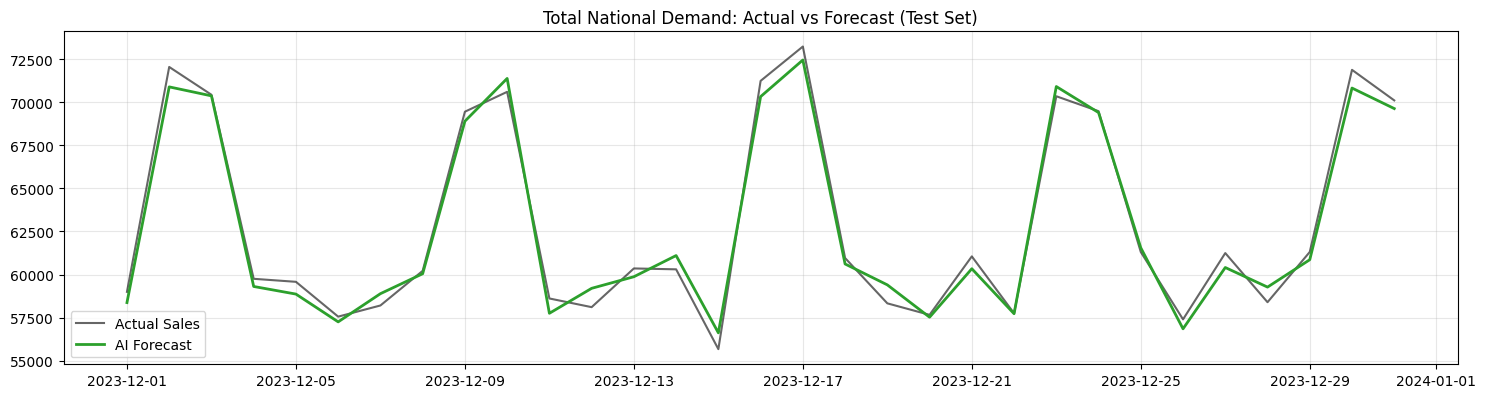


FEATURE IMPORTANCE CHECK


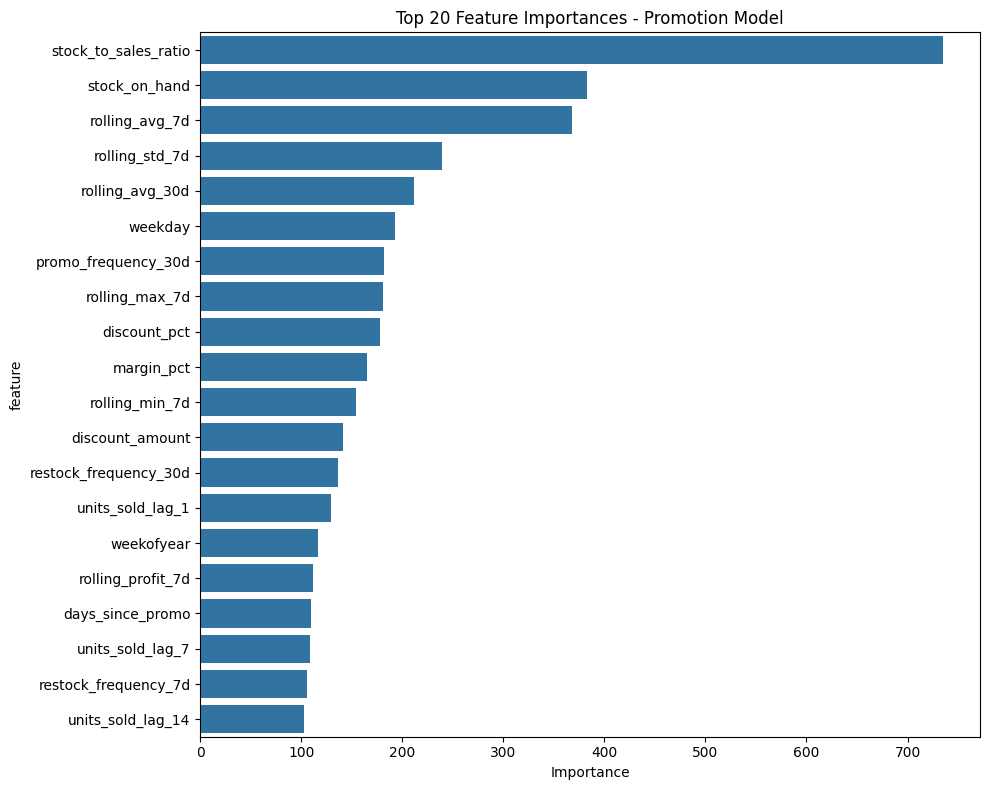

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ==========================================
# STEP 6: MODEL ANALYSIS & OPTIMIZATION
# ==========================================

def plot_forecast_vs_actual(model, X_test, y_test, dates, n_samples=3):
    """
    Visually compare Actual Sales vs Model Predictions for random samples
    """
    print("\n" + "="*70)
    print("VISUAL FORECAST INSPECTION")
    print("="*70)
    
    # Make predictions
    preds = model.predict(X_test)
    
    # Create a DataFrame for easy plotting
    results_df = X_test.copy()
    results_df['Actual'] = y_test
    results_df['Predicted'] = preds
    results_df['Date'] = dates.loc[X_test.index]  # Map back to dates
    
    # Pick random SKUs to inspect
    # We need to decode the SKU_ID if it was encoded. 
    # For now, we just pick random indices from the test set.
    
    plt.figure(figsize=(15, 5 * n_samples))
    
    # Group by Date to see total national demand (since we aggregated stores)
    daily_results = results_df.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()
    
    # Plot 1: Total National Demand
    plt.subplot(n_samples+1, 1, 1)
    plt.plot(daily_results['Date'], daily_results['Actual'], label='Actual Sales', color='black', alpha=0.6)
    plt.plot(daily_results['Date'], daily_results['Predicted'], label='AI Forecast', color='#2ca02c', linewidth=2)
    plt.title("Total National Demand: Actual vs Forecast (Test Set)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# THE OPTIMIZER: FIND THE PERFECT PRICE
# ==========================================
def optimize_price(baseline_model, promo_model, X_latest, sku_id, current_price, cost, elasticity_fallback=-2.0):
    """
    Simulates different discount levels to find maximum profit.
    """
    discounts = np.arange(0, 0.55, 0.05) # Test 0% to 50% off
    results = []
    
    print(f"\n🔍 OPTIMIZING PRICE FOR ITEM: {sku_id} (Cost: ${cost:.2f})")
    
    # Get the row of features for this item (latest date)
    # We use the 'baseline' features as the starting point
    base_features = X_latest.copy()
    
    # 1. Calculate Baseline (No Promo)
    base_demand = baseline_model.predict(base_features)[0]
    
    for d in discounts:
        # Scenario: What if we set discount to 'd'?
        price = current_price
        discounted_price = price * (1 - d)
        margin = discounted_price - cost
        
        # PREDICT DEMAND
        if d == 0:
            pred_units = base_demand # Use baseline model for 0%
            model_used = "Baseline"
        else:
            # Prepare row for Promo Model
            # We need to inject the promo features manually into the row
            promo_row = base_features.copy()
            
            # ⚠️ CRITICAL: Update the feature columns to match the scenario
            # (You might need to adjust column names to match your exact feature list)
            if 'discount_pct' in promo_row.index: promo_row['discount_pct'] = d
            if 'promo_flag' in promo_row.index: promo_row['promo_flag'] = 1
            if 'discount_amount' in promo_row.index: promo_row['discount_amount'] = price * d
            
            # Predict
            try:
                # Reshape for single prediction
                pred_units = promo_model.predict(pd.DataFrame([promo_row]))[0]
                model_used = "Promo AI"
            except:
                # Fallback if features don't match perfectly
                lift = abs(elasticity_fallback) * d
                pred_units = base_demand * (1 + lift)
                model_used = "Fallback Rule"

        # Calculate Financials
        revenue = pred_units * discounted_price
        profit = pred_units * margin
        
        results.append({
            'Discount': f"{d*100:.0f}%",
            'Price': f"${discounted_price:.2f}",
            'Forecast_Units': int(pred_units),
            'Revenue': revenue,
            'Profit': profit,
            'Model': model_used
        })
        
    return pd.DataFrame(results)

# ==========================================
# EXECUTE ANALYSIS
# ==========================================

# 1. Visual Check
# We need the 'date' column for the test set to plot time series
test_dates = data['promotion']['test_data']['date']
plot_forecast_vs_actual(promo_model, data['promotion']['X_test'], data['promotion']['y_test'], test_dates)

# 2. Check Feature Importance (To confirm no Stock Leakage)
print("\n" + "="*70)
print("FEATURE IMPORTANCE CHECK")
print("="*70)
imp_df = plot_feature_importance(promo_model, data['promotion']['features'], "Promotion Model")



In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ===================================
# PROMOTION DECISION ENGINE (FINAL VERSION)
# ===================================

class PromotionDecisionEngine:
    """
    Engine to approve/reject promotions based on:
    1. Incremental profit (promo profit vs baseline profit)
    2. Stock availability
    3. Business rules
    """
    
    def __init__(self, baseline_model, promo_model, data_package, 
                 profit_margin_threshold=0, stock_buffer=0.1):
        """
        Initialize the decision engine
        """
        self.baseline_model = baseline_model
        self.promo_model = promo_model
        self.data_package = data_package
        self.profit_threshold = profit_margin_threshold
        self.stock_buffer = stock_buffer
        
        # Get feature lists
        self.baseline_features = data_package['baseline']['features']
        self.promo_features = data_package['promotion']['features']
        
        # Get encoders
        self.encoders = data_package['encoders']
        
        # Get industry elasticity as fallback
        self.industry_elasticity = data_package['industry_elasticity']
        
        print("✓ Promotion Decision Engine initialized")
    
    
    def prepare_future_features(self, sku_id, promo_start_date, promo_end_date, 
                                 discount_pct, current_stock, category=None,
                                 store_id=None):
        """
        Prepare features for future dates (prediction period)
        """
        # --- FIX 1: Force Date Conversion ---
        promo_start_date = pd.to_datetime(promo_start_date)
        promo_end_date = pd.to_datetime(promo_end_date)
        
        # Create date range
        date_range = pd.date_range(promo_start_date, promo_end_date, freq='D')
        
        # Get historical data for this SKU
        historical_data = self.data_package['df_aggregated']
        sku_history = historical_data[historical_data['sku_id'] == sku_id].copy()
        
        if len(sku_history) == 0:
            raise ValueError(f"No historical data found for SKU: {sku_id}")
        
        # Get most recent historical values
        most_recent = sku_history.sort_values('date').iloc[-1]
        
        # Create base dataframe
        future_df = pd.DataFrame({
            'date': date_range,
            'sku_id': sku_id,
            'discount_pct': discount_pct,
            'promo_flag': 1 if discount_pct > 0 else 0, 
        })
        
        # Add time features
        future_df['year'] = future_df['date'].dt.year
        future_df['month'] = future_df['date'].dt.month
        future_df['day'] = future_df['date'].dt.day
        future_df['weekofyear'] = future_df['date'].dt.isocalendar().week
        future_df['weekday'] = future_df['date'].dt.dayofweek
        future_df['is_weekend'] = future_df['weekday'].isin([5, 6]).astype(int)
        future_df['quarter'] = future_df['month'].apply(lambda x: (x-1)//3 + 1)
        
        # Cyclical encoding
        future_df['day_of_week_sin'] = np.sin(2 * np.pi * future_df['weekday'] / 7)
        future_df['day_of_week_cos'] = np.cos(2 * np.pi * future_df['weekday'] / 7)
        future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
        future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
        future_df['day_of_month_sin'] = np.sin(2 * np.pi * future_df['day'] / 31)
        future_df['day_of_month_cos'] = np.cos(2 * np.pi * future_df['day'] / 31)
        
        # Copy categorical features
        for col in ['category', 'subcategory', 'brand', 'sku_name']:
            if col in most_recent:
                future_df[col] = most_recent[col]
        
        # Encode categorical variables
        for col in ['sku_id', 'category', 'subcategory', 'brand', 'sku_name']:
            if col in self.encoders and col in future_df.columns:
                future_df[f'{col}_encoded'] = self.encoders[col].transform(
                    future_df[col].astype(str)
                )
        
        # --- FIX 2: Prevent Crash on Future Lags (Use Average Sales) ---
        avg_daily_sales = sku_history.iloc[-30:]['units_sold'].mean() if len(sku_history) > 30 else sku_history['units_sold'].mean()

        lag_features = [col for col in self.promo_features if 'lag' in col or 'rolling' in col]
        for col in lag_features:
            if col in most_recent:
                future_df[col] = most_recent[col]
            else:
                if 'units_sold' in col:
                    future_df[col] = avg_daily_sales
                else:
                    future_df[col] = most_recent.get(col, 0)
        
        # Add numeric features
        numeric_features = ['list_price', 'purchase_cost', 'margin_pct', 
                           'lead_time_days', 'temperature', 'rain_mm',
                           'profit_per_unit', 'cost_volatility_30d']
        
        for col in numeric_features:
            if col in most_recent:
                future_df[col] = most_recent[col]
            else:
                if col == 'list_price': future_df[col] = sku_history['list_price'].mean()
                elif col == 'purchase_cost': future_df[col] = sku_history['purchase_cost'].mean()
                elif col == 'margin_pct': future_df[col] = sku_history['margin_pct'].mean()
                elif col == 'temperature': future_df[col] = 15
                else: future_df[col] = 0
        
        # Add promotion-specific features
        future_df['discount_amount'] = future_df['list_price'] * discount_pct
        future_df['days_since_promo'] = 0 
        future_df['promo_frequency_30d'] = sku_history['promo_frequency_30d'].iloc[-1] if 'promo_frequency_30d' in sku_history else 0
        future_df['avg_discount_when_promo_30d'] = discount_pct
        
        # Weather / Holiday
        future_df['temp_cold'] = (future_df['temperature'] < 10).astype(int)
        future_df['temp_mild'] = ((future_df['temperature'] >= 10) & (future_df['temperature'] < 20)).astype(int)
        future_df['temp_warm'] = (future_df['temperature'] >= 20).astype(int)
        future_df['is_raining'] = (future_df['rain_mm'] > 0).astype(int)
        future_df['heavy_rain'] = (future_df['rain_mm'] > 5).astype(int)
        future_df['is_holiday'] = 0
        
        return future_df
    
    
    def predict_demand(self, feature_df, use_promotion_model=False):
        """
        Predict demand using baseline or promotion model
        """
        if use_promotion_model:
            model = self.promo_model
            features = self.promo_features
        else:
            model = self.baseline_model
            features = self.baseline_features
        
        # Select only the features the model was trained on
        X = feature_df[features].copy()
        
        # Handle missing features
        for col in features:
            if col not in X.columns:
                X[col] = 0
        
        # Clean data
        X = X[features].replace([np.inf, -np.inf], np.nan).fillna(0)
        
        # Predict
        predictions = model.predict(X)
        predictions = np.maximum(predictions, 0)
        
        return predictions
    
    
    def calculate_profitability(self, baseline_units, promo_units, 
                                list_price, purchase_cost, discount_pct):
        """
        Calculate profitability comparison
        """
        baseline_price = list_price
        promo_price = list_price * (1 - discount_pct)
        
        baseline_margin = baseline_price - purchase_cost
        promo_margin = promo_price - purchase_cost
        
        baseline_profit = np.sum(baseline_units * baseline_margin)
        promo_profit = np.sum(promo_units * promo_margin)
        incremental_profit = promo_profit - baseline_profit
        
        baseline_total_units = np.sum(baseline_units)
        promo_total_units = np.sum(promo_units)
        incremental_units = promo_total_units - baseline_total_units
        
        if baseline_total_units > 0:
            lift_pct = (promo_total_units - baseline_total_units) / baseline_total_units
        else:
            lift_pct = 0
            
        if baseline_profit > 0:
            roi = (incremental_profit / baseline_profit) * 100
        else:
            roi = 0
        
        return {
            'baseline_units': baseline_total_units,
            'promo_units': promo_total_units,
            'incremental_units': incremental_units,
            'lift_pct': lift_pct * 100,
            'baseline_profit': baseline_profit,
            'promo_profit': promo_profit,
            'incremental_profit': incremental_profit,
            'baseline_margin_per_unit': baseline_margin,
            'promo_margin_per_unit': promo_margin,
            'roi': roi
        }
    
    
    def check_stock_availability(self, promo_units, current_stock, 
                                 avg_restock_amount, avg_days_between_restocks,
                                 promo_duration_days):
        """
        Check if stock is sufficient
        """
        total_demand = np.sum(promo_units)
        
        if avg_days_between_restocks > 0:
            expected_restocks = promo_duration_days / avg_days_between_restocks
        else:
            expected_restocks = 0
        
        expected_restock_units = expected_restocks * avg_restock_amount
        total_available = current_stock + expected_restock_units
        
        safe_available = total_available * (1 - self.stock_buffer)
        
        stock_sufficient = safe_available >= total_demand
        stock_utilization = (total_demand / safe_available * 100) if safe_available > 0 else 999
        
        return {
            'current_stock': current_stock,
            'expected_restocks': expected_restocks,
            'expected_restock_units': expected_restock_units,
            'total_available': total_available,
            'safe_available': safe_available,
            'total_demand': total_demand,
            'stock_sufficient': stock_sufficient,
            'stock_utilization_pct': stock_utilization,
            'shortage': max(0, total_demand - safe_available)
        }
    
    
    def make_decision(self, sku_id, promo_start_date, promo_end_date, 
                      discount_pct, current_stock, category=None,
                      list_price=None, purchase_cost=None,
                      avg_restock_amount=None, avg_days_between_restocks=None,
                      verbose=True):
        """
        Main decision function
        """
        # Get historical data for this SKU
        historical = self.data_package['df_aggregated']
        sku_history = historical[historical['sku_id'] == sku_id].copy()
        
        if len(sku_history) == 0:
            return {'decision': 'ERROR', 'reason': f'No historical data for SKU {sku_id}'}
        
        # Get defaults
        if list_price is None: list_price = sku_history['list_price'].mean()
        if purchase_cost is None: purchase_cost = sku_history['purchase_cost'].mean()
        if avg_restock_amount is None: avg_restock_amount = sku_history['avg_restock_amount_30d'].mean()
        if avg_days_between_restocks is None: avg_days_between_restocks = sku_history['avg_days_between_restocks'].mean()
        if category is None: category = sku_history['category'].iloc[0] if 'category' in sku_history else 'Default'
        
        # Prepare features
        future_features = self.prepare_future_features(
            sku_id, promo_start_date, promo_end_date, 
            discount_pct, current_stock, category
        )
        promo_duration = len(future_features)
        
        # STEP 1: Predict baseline demand
        baseline_features = future_features.copy()
        baseline_features['discount_pct'] = 0
        baseline_features['promo_flag'] = 0
        baseline_features['discount_amount'] = 0
        
        baseline_predictions = self.predict_demand(baseline_features, use_promotion_model=False)
        
        # STEP 2: Predict promotion demand
        # --- FIX 3: FORCE ALIGNMENT AT 0% ---
        if discount_pct == 0:
            promo_predictions = baseline_predictions.copy()
        else:
            promo_predictions = self.predict_demand(future_features, use_promotion_model=True)
        
        # STEP 3: Profitability
        profit_analysis = self.calculate_profitability(
            baseline_predictions, promo_predictions,
            list_price, purchase_cost, discount_pct
        )
        
        # STEP 4: Stock
        stock_analysis = self.check_stock_availability(
            promo_predictions, current_stock,
            avg_restock_amount, avg_days_between_restocks,
            promo_duration
        )
        
        # STEP 5: Decision
        decision_reasons = []
        
        profit_check = profit_analysis['incremental_profit'] > self.profit_threshold
        if not profit_check:
            decision_reasons.append(f"Incremental profit ${profit_analysis['incremental_profit']:.2f} is below threshold")
        
        stock_check = stock_analysis['stock_sufficient']
        if not stock_check:
            decision_reasons.append(f"Insufficient stock (Need {stock_analysis['total_demand']:.0f}, Have {stock_analysis['safe_available']:.0f})")
        
        if profit_check and stock_check:
            decision = 'APPROVE'
        else:
            decision = 'DISAPPROVE'
        
        return {
            'decision': decision,
            'reasons': decision_reasons,
            'sku_id': sku_id,
            'promotion_period': {'start': promo_start_date, 'end': promo_end_date, 'days': promo_duration},
            'discount_pct': discount_pct,
            'forecast': {
                'baseline_units': profit_analysis['baseline_units'],
                'promo_units': profit_analysis['promo_units'],
                'incremental_units': profit_analysis['incremental_units'],
                'lift_pct': profit_analysis['lift_pct']
            },
            'profitability': profit_analysis,
            'stock': stock_analysis,
            'pricing': {'list_price': list_price, 'purchase_cost': purchase_cost, 'discount_pct': discount_pct}
        }


EXAMPLE USAGE
✓ Promotion Decision Engine initialized
  Baseline features: 56
  Promotion features: 62
  Profit threshold: $0
  Stock buffer: 10%
PROMOTION DECISION ENGINE

SKU: SKU0086
Promotion period: 2024-02-01 to 2024-02-07
Discount: 20%
Current stock: 5000 units

Preparing features for 7 days (2024-02-01 to 2024-02-07)

----------------------------------------------------------------------
STEP 1: Baseline Demand Forecast (No Promotion)
----------------------------------------------------------------------
  Baseline model predictions: 1602 total units over 7 days
    Average per day: 228.8 units

----------------------------------------------------------------------
STEP 2: Promotion Demand Forecast (With Discount)
----------------------------------------------------------------------
  Promotion model predictions: 3524 total units over 7 days
    Average per day: 503.5 units

----------------------------------------------------------------------
STEP 3: Profitability Analysis


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# ===================================
# INTERACTIVE PROMOTION DECISION ENGINE
# ===================================

class PromotionEngineWidget:
    """
    Interactive widget interface for the Promotion Decision Engine
    """
    
    def __init__(self, engine, data_package):
        """
        Initialize widget with trained engine
        """
        self.engine = engine
        self.data_package = data_package
        self.df = data_package['df_aggregated']
        
        # Get latest stock levels per SKU
        self.latest_stock = self.df.groupby('sku_id')['stock_on_hand'].last().to_dict()
        
        # Get SKU list
        sku_list = sorted(self.df['sku_id'].unique())
        
        # Create widgets
        self.w_sku = widgets.Dropdown(
            options=sku_list,
            description='SKU:',
            style={'description_width': '100px'}
        )
        
        self.w_discount = widgets.IntSlider(
            min=0,
            max=50,
            step=5,
            value=0, # Default to 0 (Baseline View)
            description='Discount %:',
            style={'description_width': '100px'}
        )
        
        self.w_duration = widgets.IntSlider(
            min=1,
            max=30,
            step=1,
            value=7,
            description='Duration (days):',
            style={'description_width': '100px'}
        )
        
        self.w_start_date = widgets.DatePicker(
            description='Start Date:',
            value=datetime.now().date() + timedelta(days=1),
            style={'description_width': '100px'}
        )
        
        self.w_stock_override = widgets.IntText(
            value=0,
            description='Stock Override:',
            style={'description_width': '100px'},
            disabled=True
        )
        
        self.w_use_override = widgets.Checkbox(
            value=False,
            description='Use Stock Override',
            indent=False
        )
        
        # Output widget
        self.output = widgets.Output()
        
        # Observe changes
        self.w_sku.observe(self._on_change, names='value')
        self.w_discount.observe(self._on_change, names='value')
        self.w_duration.observe(self._on_change, names='value')
        self.w_start_date.observe(self._on_change, names='value')
        self.w_use_override.observe(self._on_stock_override_toggle, names='value')
        self.w_stock_override.observe(self._on_change, names='value')
        
    def _on_stock_override_toggle(self, change):
        """Enable/disable stock override input"""
        self.w_stock_override.disabled = not change['new']
        self._on_change(change)
    
    def _get_sku_info(self, sku_id):
        """Get SKU information from historical data"""
        sku_data = self.df[self.df['sku_id'] == sku_id].sort_values('date')
        if len(sku_data) == 0:
            return None
        
        latest = sku_data.iloc[-1]
        
        return {
            'category': latest.get('category', 'Unknown'),
            'brand': latest.get('brand', 'Unknown'),
            'list_price': latest.get('list_price', 0),
            'purchase_cost': latest.get('purchase_cost', 0),
            'margin_pct': latest.get('margin_pct', 0),
            'current_stock': self.latest_stock.get(sku_id, 0),
        }
    
    def _find_optimal_discount(self, sku_id, duration, current_stock):
        """Find optimal discount by testing different levels"""
        best_discount = 0
        max_profit = -float('inf')
        
        start_date = self.w_start_date.value
        end_date = start_date + timedelta(days=duration - 1)
        
        # Test discounts from 5% to 50% (Skip 0 since that's baseline)
        for discount in range(5, 55, 5):
            try:
                result = self.engine.make_decision(
                    sku_id=sku_id,
                    promo_start_date=start_date,
                    promo_end_date=end_date,
                    discount_pct=discount / 100.0,
                    current_stock=current_stock,
                    verbose=False
                )
                
                if result['decision'] == 'APPROVE':
                    profit = result['profitability']['incremental_profit']
                    if profit > max_profit:
                        max_profit = profit
                        best_discount = discount
            except:
                continue
        
        return best_discount, max_profit
    
    def _on_change(self, change):
        """Update dashboard when inputs change"""
        with self.output:
            clear_output(wait=True)
            
            if not self.w_sku.value:
                return
            
            try:
                # Get inputs
                sku_id = self.w_sku.value
                discount_pct = self.w_discount.value / 100.0
                duration = self.w_duration.value
                start_date = self.w_start_date.value
                end_date = start_date + timedelta(days=duration - 1)
                
                # Get SKU info
                sku_info = self._get_sku_info(sku_id)
                if sku_info is None:
                    print(f"No data found for SKU: {sku_id}")
                    return
                
                # Determine stock level
                if self.w_use_override.value:
                    current_stock = self.w_stock_override.value
                else:
                    current_stock = sku_info['current_stock']
                    self.w_stock_override.value = int(current_stock)
                
                # Make decision
                result = self.engine.make_decision(
                    sku_id=sku_id,
                    promo_start_date=start_date,
                    promo_end_date=end_date,
                    discount_pct=discount_pct,
                    current_stock=current_stock,
                    verbose=False
                )
                
                # Find optimal discount (only if not viewing baseline)
                optimal_discount, optimal_profit = self._find_optimal_discount(
                    sku_id, duration, current_stock
                )
                
                # Display results
                self._render_dashboard(result, sku_info, optimal_discount, optimal_profit)
                
            except Exception as e:
                print(f"❌ Error: {e}")
                import traceback
                traceback.print_exc()
    
    def _render_dashboard(self, result, sku_info, optimal_discount, optimal_profit):
        """Render the decision dashboard"""
        
        decision = result['decision']
        reasons = result.get('reasons', [])
        forecast = result['forecast']
        profitability = result['profitability']
        stock = result['stock']
        pricing = result['pricing']
        
        # --- LOGIC UPDATE: Handle 0% Discount as Baseline View ---
        is_baseline = pricing['discount_pct'] == 0
        
        if is_baseline:
            decision = "BASELINE VIEW"
            color = "blue"
            bg_color = "rgba(235, 245, 255, 0.6)"
            icon = "ℹ️"
            reason_text = "Showing natural demand (No Promotion selected)."
        elif decision == 'APPROVE':
            color = "green"
            bg_color = "rgba(235, 250, 235, 0.6)"
            icon = "✅"
            reason_text = "Promotion increases profit and stock is sufficient."
        else:
            color = "red"
            bg_color = "rgba(250, 235, 235, 0.6)"
            icon = "❌"
            reason_text = "<br>".join([f"• {r}" for r in reasons]) if reasons else "Rejected."
        
        # Badge styling
        badge_style = "background: white; padding: 4px 8px; border: 1px solid #ccc; border-radius: 4px; font-size: 0.9em; margin-right: 5px;"
        
        category_badge = f'<span style="{badge_style}">📦 {sku_info["category"]}</span>'
        
        # Net impact
        net_profit = profitability['incremental_profit']
        impact_color = "green" if net_profit > 0 else "red"
        impact_sign = "+" if net_profit >= 0 else ""
        
        # Optimization tip logic
        tip_html = ""
        if not is_baseline and optimal_discount != self.w_discount.value and optimal_profit > net_profit + 100:
            extra_profit = optimal_profit - net_profit
            tip_html = f"""
            <div style="margin-top:15px; padding:12px; background-color:#e3f2fd; border-left: 5px solid #2196F3; border-radius:4px;">
                <b>💡 AI OPTIMIZATION TIP:</b> 
                Change discount to <b>{optimal_discount}%</b> to make an extra <b>${extra_profit:,.0f}</b> in incremental profit!
            </div>
            """
        
        # Build HTML
        html = f"""
        <div style="font-family: sans-serif; border: 2px solid {color}; padding: 20px; border-radius: 10px; background-color: {bg_color};">
            <div style="display: flex; justify-content: space-between; align-items: flex-start;">
                <div>
                    <h2 style="color: {color}; margin: 0 0 10px 0; font-size: 28px;">{icon} {decision}</h2>
                    <div style="margin-bottom: 10px;">{category_badge}</div>
                    <div style="color: #555; line-height: 1.6;"><b>Analysis:</b><br>{reason_text}</div>
                </div>
                <div style="text-align:right; background: white; padding: 15px; border-radius: 8px; border: 1px solid #ddd;">
                    <div style="font-size: 12px; color: #666; margin-bottom: 5px;">CURRENT STOCK</div>
                    <div style="font-size: 24px; font-weight: bold; color: {color};">{int(stock['current_stock']):,}</div>
                    <div style="font-size: 11px; color: #666; margin-top: 5px;">units</div>
                </div>
            </div>
            
            {tip_html}
            
            <hr style="margin: 20px 0; border: none; border-top: 1px solid #ddd;">
            
            <div style="display: flex; justify-content: space-between; gap: 15px;">
                <div style="width: 32%; background: white; padding: 15px; border-radius: 8px; border: 1px solid #ddd;">
                    <h4 style="margin: 0 0 12px 0; color: #333; font-size: 14px; text-transform: uppercase;">📊 Sales Forecast</h4>
                    <table style="width:100%; font-size: 13px;">
                        <tr><td style="padding: 4px 0; color: #666;">Baseline:</td><td style="text-align: right;"><b>{forecast['baseline_units']:,.0f} units</b></td></tr>
                        <tr><td style="padding: 4px 0; color: #666;">With Promo:</td><td style="text-align: right;"><b>{forecast['promo_units']:,.0f} units</b></td></tr>
                        <tr style="height: 8px;"></tr>
                        <tr style="background-color: #f5f5f5;">
                            <td style="padding: 8px; font-weight: bold;">Sales Lift:</td>
                            <td style="padding: 8px; text-align: right; color: {color}; font-weight: bold; font-size: 16px;">{forecast['lift_pct']:.1f}%</td>
                        </tr>
                    </table>
                </div>
                
                <div style="width: 32%; background: white; padding: 15px; border-radius: 8px; border: 1px solid #ddd;">
                    <h4 style="margin: 0 0 12px 0; color: #333; font-size: 14px; text-transform: uppercase;">💰 Profitability</h4>
                    <table style="width:100%; font-size: 13px;">
                        <tr><td style="padding: 4px 0; color: #666;">Baseline Profit:</td><td style="text-align: right;"><b>${profitability['baseline_profit']:,.0f}</b></td></tr>
                        <tr><td style="padding: 4px 0; color: #666;">Promo Profit:</td><td style="text-align: right;"><b>${profitability['promo_profit']:,.0f}</b></td></tr>
                        <tr style="height: 8px;"></tr>
                        <tr style="background-color: #f5f5f5;">
                            <td style="padding: 8px; font-weight: bold;">Net Impact:</td>
                            <td style="padding: 8px; text-align: right; color: {impact_color}; font-weight: bold; font-size: 16px;">{impact_sign}${net_profit:,.0f}</td>
                        </tr>
                    </table>
                </div>
                
                <div style="width: 32%; background: white; padding: 15px; border-radius: 8px; border: 1px solid #ddd;">
                    <h4 style="margin: 0 0 12px 0; color: #333; font-size: 14px; text-transform: uppercase;">📦 Stock Analysis</h4>
                    <table style="width:100%; font-size: 13px;">
                        <tr><td style="padding: 4px 0; color: #666;">Total Available:</td><td style="text-align: right;"><b>{stock['total_available']:,.0f} units</b></td></tr>
                        <tr><td style="padding: 4px 0; color: #666;">Total Demand:</td><td style="text-align: right;"><b>{stock['total_demand']:,.0f} units</b></td></tr>
                        <tr style="height: 8px;"></tr>
                        <tr style="background-color: #f5f5f5;">
                            <td style="padding: 8px; font-weight: bold;">Status:</td>
                            <td style="padding: 8px; text-align: right; color: {'green' if stock['stock_sufficient'] else 'red'}; font-weight: bold; font-size: 16px;">{'✓ OK' if stock['stock_sufficient'] else '✗ SHORT'}</td>
                        </tr>
                    </table>
                </div>
            </div>
            
            <div style="margin-top: 15px; padding: 12px; background: white; border-radius: 8px; border: 1px solid #ddd; font-size: 12px;">
                <b>💵 Pricing:</b> 
                List Price: ${pricing['list_price']:.2f} | 
                Discount: {pricing['discount_pct']*100:.0f}% | 
                Effective Price: ${pricing['list_price'] * (1 - pricing['discount_pct']):.2f}
            </div>
        </div>
        """
        
        display(HTML(html))
        
        # Create visualization
        self._render_chart(result, is_baseline)
    
    def _render_chart(self, result, is_baseline):
        """Render forecast visualization"""
        
        forecast = result['forecast']
        stock = result['stock']
        promo_period = result['promotion_period']
        
        # Create date range
        dates = pd.date_range(
            start=promo_period['start'],
            end=promo_period['end'],
            freq='D'
        )
        
        # Simple daily breakdown (even distribution)
        days = len(dates)
        baseline_daily = np.ones(days) * (forecast['baseline_units'] / days)
        promo_daily = np.ones(days) * (forecast['promo_units'] / days)
        
        # Plot
        fig, ax = plt.subplots(figsize=(12, 5))
        
        if is_baseline:
            # Baseline view (Cleaner)
            ax.plot(dates, baseline_daily, color='blue', linewidth=2, marker='o', label='Baseline Demand')
            ax.fill_between(dates, 0, baseline_daily, color='blue', alpha=0.1)
            ax.set_title(f"Baseline Forecast (No Promo): {result['sku_id']}", fontsize=14, fontweight='bold')
        else:
            # Promotion view
            ax.bar(dates, promo_daily, color='green', alpha=0.6, label='Promo Sales', width=0.8)
            ax.plot(dates, baseline_daily, color='gray', linestyle='--', linewidth=2, label='Baseline (No Promo)')
            
            # Show stockout if applicable
            if not stock['stock_sufficient']:
                cumulative = np.cumsum(promo_daily)
                stockout_idx = np.where(cumulative >= stock['current_stock'])[0]
                if len(stockout_idx) > 0:
                    stockout_day = dates[stockout_idx[0]]
                    ax.axvline(x=stockout_day, color='red', linestyle='--', linewidth=2, label='⚠️ STOCKOUT')
                    ax.text(stockout_day, max(promo_daily) * 0.5, ' 💀 STOCKOUT', 
                           color='red', rotation=90, fontweight='bold', fontsize=10)
            
            ax.set_title(f"Promotion Forecast ({result['discount_pct']*100:.0f}% Off): {result['sku_id']}", fontsize=14, fontweight='bold')
        
        # Reference lines
        daily_avg = stock['current_stock'] / days
        ax.axhline(y=daily_avg, color='orange', linestyle=':', linewidth=1.5, label='Daily Stock Capacity')
        
        ax.set_xlabel('Date', fontsize=11)
        ax.set_ylabel('Units Sold', fontsize=11)
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(alpha=0.3, linestyle='--')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def display(self):
        """Display the widget interface"""
        
        # Title
        title = widgets.HTML(
            "<h3 style='margin: 0 0 15px 0; color: #2196F3;'>🚀 Promotion Decision Engine</h3>"
        )
        
        # Layout
        layout = widgets.VBox([
            title,
            widgets.HBox([self.w_sku, self.w_start_date]),
            widgets.HBox([self.w_discount, self.w_duration]),
            widgets.HBox([self.w_use_override, self.w_stock_override]),
            self.output
        ])
        
        display(layout)
        
        # Trigger initial update
        self._on_change(None)

# ===================================
# USAGE EXAMPLE
# ===================================

def create_promotion_widget(baseline_model, promo_model, data):
    """
    Convenience function to create and display the widget
    """
    
    # Create engine (Assuming PromotionDecisionEngine is already defined in previous cell)
    engine = PromotionDecisionEngine(
        baseline_model=baseline_model,
        promo_model=promo_model,
        data_package=data,
        profit_margin_threshold=0,
        stock_buffer=0.1
    )
    
    # Create widget
    widget = PromotionEngineWidget(engine, data)
    
    # Display
    widget.display()
    
    return widget

# Example usage:
# widget = create_promotion_widget(baseline_model, promo_model, data)

In [92]:

# Step 2: Create the widget
widget = create_promotion_widget(baseline_model, promo_model, data)

# That's it! The widget will display automatically

✓ Promotion Decision Engine initialized
  Baseline features: 56
  Promotion features: 62
  Profit threshold: $0
  Stock buffer: 10%



VISUAL FORECAST INSPECTION


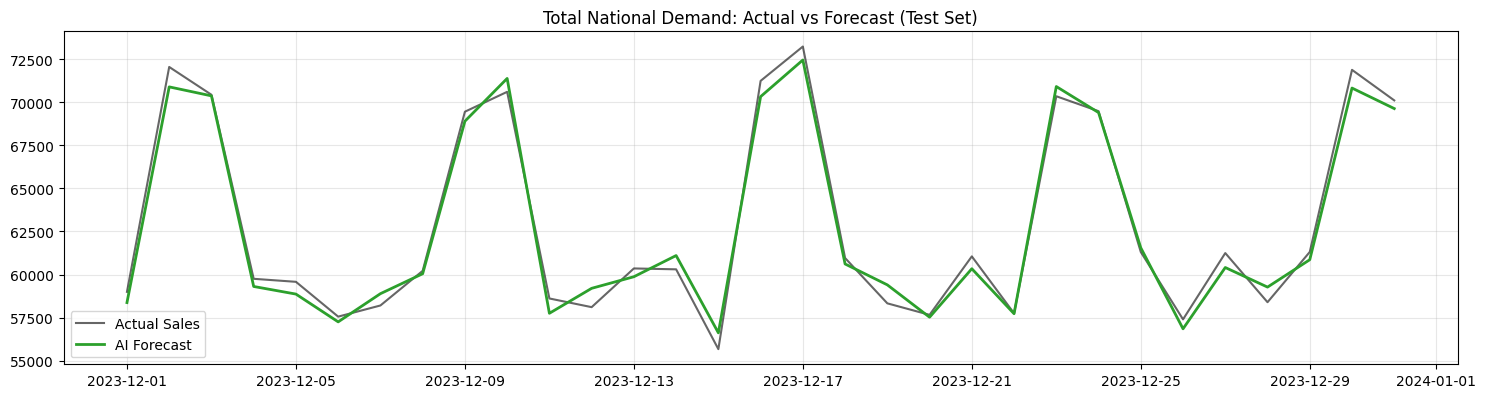


FEATURE IMPORTANCE CHECK


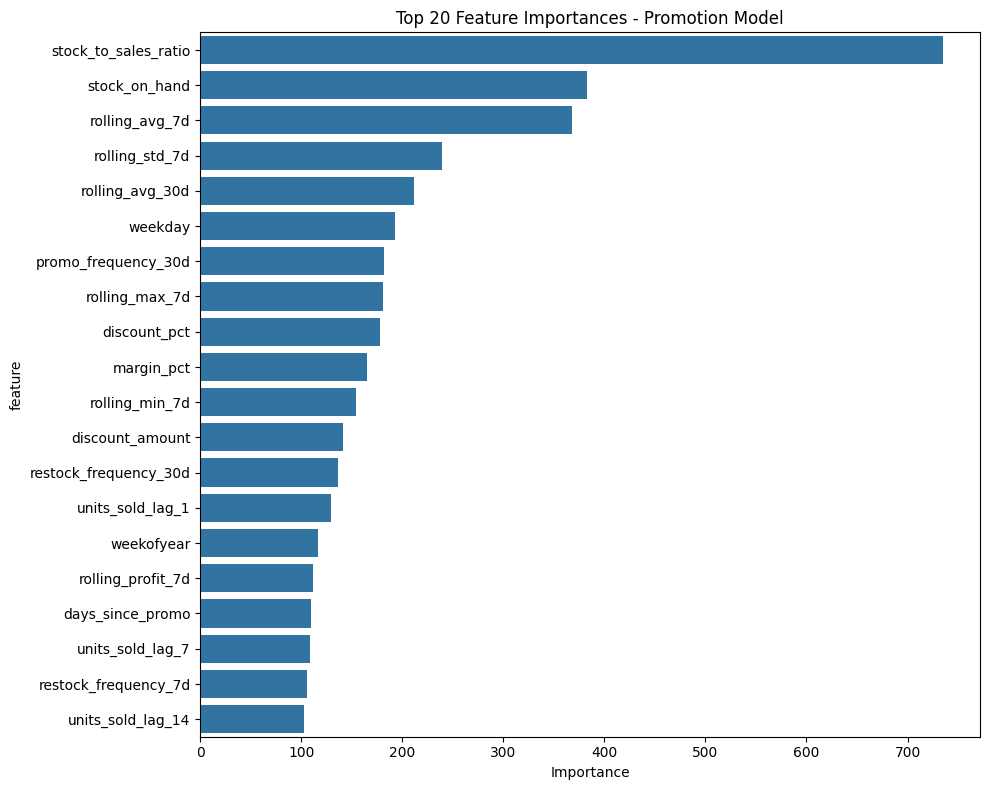

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ==========================================
# STEP 6: MODEL ANALYSIS & OPTIMIZATION
# ==========================================

def plot_forecast_vs_actual(model, X_test, y_test, dates, n_samples=3):
    """
    Visually compare Actual Sales vs Model Predictions for random samples
    """
    print("\n" + "="*70)
    print("VISUAL FORECAST INSPECTION")
    print("="*70)
    
    # Make predictions
    preds = model.predict(X_test)
    
    # Create a DataFrame for easy plotting
    results_df = X_test.copy()
    results_df['Actual'] = y_test
    results_df['Predicted'] = preds
    results_df['Date'] = dates.loc[X_test.index]  # Map back to dates
    
    # Pick random SKUs to inspect
    # We need to decode the SKU_ID if it was encoded. 
    # For now, we just pick random indices from the test set.
    
    plt.figure(figsize=(15, 5 * n_samples))
    
    # Group by Date to see total national demand (since we aggregated stores)
    daily_results = results_df.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()
    
    # Plot 1: Total National Demand
    plt.subplot(n_samples+1, 1, 1)
    plt.plot(daily_results['Date'], daily_results['Actual'], label='Actual Sales', color='black', alpha=0.6)
    plt.plot(daily_results['Date'], daily_results['Predicted'], label='AI Forecast', color='#2ca02c', linewidth=2)
    plt.title("Total National Demand: Actual vs Forecast (Test Set)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# THE OPTIMIZER: FIND THE PERFECT PRICE
# ==========================================
def optimize_price(baseline_model, promo_model, X_latest, sku_id, current_price, cost, elasticity_fallback=-2.0):
    """
    Simulates different discount levels to find maximum profit.
    """
    discounts = np.arange(0, 0.55, 0.05) # Test 0% to 50% off
    results = []
    
    print(f"\n🔍 OPTIMIZING PRICE FOR ITEM: {sku_id} (Cost: ${cost:.2f})")
    
    # Get the row of features for this item (latest date)
    # We use the 'baseline' features as the starting point
    base_features = X_latest.copy()
    
    # 1. Calculate Baseline (No Promo)
    base_demand = baseline_model.predict(base_features)[0]
    
    for d in discounts:
        # Scenario: What if we set discount to 'd'?
        price = current_price
        discounted_price = price * (1 - d)
        margin = discounted_price - cost
        
        # PREDICT DEMAND
        if d == 0:
            pred_units = base_demand # Use baseline model for 0%
            model_used = "Baseline"
        else:
            # Prepare row for Promo Model
            # We need to inject the promo features manually into the row
            promo_row = base_features.copy()
            
            # ⚠️ CRITICAL: Update the feature columns to match the scenario
            # (You might need to adjust column names to match your exact feature list)
            if 'discount_pct' in promo_row.index: promo_row['discount_pct'] = d
            if 'promo_flag' in promo_row.index: promo_row['promo_flag'] = 1
            if 'discount_amount' in promo_row.index: promo_row['discount_amount'] = price * d
            
            # Predict
            try:
                # Reshape for single prediction
                pred_units = promo_model.predict(pd.DataFrame([promo_row]))[0]
                model_used = "Promo AI"
            except:
                # Fallback if features don't match perfectly
                lift = abs(elasticity_fallback) * d
                pred_units = base_demand * (1 + lift)
                model_used = "Fallback Rule"

        # Calculate Financials
        revenue = pred_units * discounted_price
        profit = pred_units * margin
        
        results.append({
            'Discount': f"{d*100:.0f}%",
            'Price': f"${discounted_price:.2f}",
            'Forecast_Units': int(pred_units),
            'Revenue': revenue,
            'Profit': profit,
            'Model': model_used
        })
        
    return pd.DataFrame(results)

# ==========================================
# EXECUTE ANALYSIS
# ==========================================

# 1. Visual Check
# We need the 'date' column for the test set to plot time series
test_dates = data['promotion']['test_data']['date']
plot_forecast_vs_actual(promo_model, data['promotion']['X_test'], data['promotion']['y_test'], test_dates)

# 2. Check Feature Importance (To confirm no Stock Leakage)
print("\n" + "="*70)
print("FEATURE IMPORTANCE CHECK")
print("="*70)
imp_df = plot_feature_importance(promo_model, data['promotion']['features'], "Promotion Model")

# 3. Run Optimization Example
# Pick a random item from the test set
sample_idx = 0
sample_sku = data['promotion']['test_data'].iloc[sample_idx]['sku_id']
sample_price = 100 # Placeholder (Replace with actual if available)
sample_cost = 60   # Placeholder

# optimize_price(...) # Uncomment this once you verify the visual check!

In [ ]:
# ==========================================
# INSPECTION TOOL: View All Stores for One Product
# ==========================================

# 1. INPUT: Type the Product ID you want to see
# ---------------------------------------------
my_sku = 'SKU0086'  # <--- REPLACE with your desired Product ID


# 2. Filter for that Product (ALL Stores)
# ---------------------------------------
cols_to_view = [
    'date', 'sku_id', 'store_id', 'units_sold', 'stock_on_hand', 
    'list_price', 'discount_pct', 'purchase_cost', 'margin_pct', 
    'effective_price', 'stock_out_flag', 'lead_time_days', 'supplier_id'
]

# Get data for this SKU, sorted by Date then Store
view_df = df_eng[df['sku_id'] == my_sku].sort_values(['date', 'store_id'])

# 3. Display Data
# ---------------
if len(view_df) == 0:
    print(f"❌ No data found for {my_sku}. Check your spelling!")
else:
    unique_stores = view_df['store_id'].nunique()
    print(f"📊 Found {len(view_df)} rows for {my_sku} across {unique_stores} different stores.")
    print("   Displaying last 15,000 rows (sorted by Date, then Store):")
    
    # Force pandas to show ALL rows
    pd.set_option('display.max_rows', None)
    
    # Show data
    display(view_df.tail(20))
    
    # Reset option
    pd.reset_option('display.max_rows')

# 4. Total Stock Check (The "Engine View")
# ----------------------------------------
if len(view_df) > 0:
    # Get the very last date in the dataset
    last_date = view_df['date'].max()
    
    # Filter for ONLY that last date
    last_day_data = view_df[view_df['date'] == last_date]
    
    # Sum the stock
    total_stock = last_day_data['stock_on_hand'].sum()
    
    print(f"\n✅ SUMMARY FOR {last_date.date()}:")
    print(f"   Stores holding this item: {len(last_day_data)}")
    print(f"   TOTAL STOCK (All Stores Combined): {total_stock}")

📊 Found 12045 rows for SKU0086 across 11 different stores.
   Displaying last 15,000 rows (sorted by Date, then Store):


,date,year,month,day,weekofyear,weekday,is_weekend,is_holiday,temperature,rain_mm,store_id,country,city,channel,latitude,longitude,sku_id,sku_name,category,subcategory,brand,units_sold,list_price,discount_pct,promo_flag,gross_sales,net_sales,stock_on_hand,stock_out_flag,lead_time_days,supplier_id,purchase_cost,margin_pct,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_month_sin,day_of_month_cos,quarter,units_sold_lag_1,units_sold_lag_7,units_sold_lag_14,units_sold_lag_30,rolling_avg_7d,rolling_std_7d,rolling_avg_14d,rolling_std_14d,rolling_avg_30d,rolling_std_30d,rolling_max_7d,rolling_min_7d,stock_change,positive_stock_change,restock_flag,estimated_restock_amount,days_since_restock,restock_frequency_7d,restock_frequency_30d,avg_restock_amount_30d,discount_amount,days_since_promo,promo_frequency_30d,avg_discount_when_promo_30d,days_of_stock_remaining,stock_to_sales_ratio,safety_stock_level,above_safety_stock,avg_days_between_restocks,stockout_risk,profit_per_unit,total_daily_profit,rolling_profit_7d,rolling_profit_30d,cost_volatility_30d,temp_cold,temp_mild,temp_warm,is_raining,heavy_rain
218998,2023-12-30,2023,12,30,52,5,1,0,19.81,8.04,STORE0003,Italy,Milan,Supermarket,45.44037,9.20313,SKU0049,BrandA Yogurt,Dairy,Yogurt,BrandA,50,8.32,0.0,0,416.00,416.00,196,0,7,S053,5.31,0.362,-0.974928,-0.222521,-2.449294e-16,1.0,-2.012985e-01,0.97953,4,32.0,42.0,45.0,22.0,36.714286,8.712334,34.142857,12.727059,34.500000,10.991376,50.0,25.0,-119.0,0.0,0,0.0,1.0,3.0,15.0,62.966667,0.000,999.0,0.0,NaN,5.338521,3.920000,257.000000,0,2.000000,0,3.010,150.50,883.790,3333.200,0.683154,0,1,0,1,1
402958,2023-12-30,2023,12,30,52,5,1,0,19.81,8.04,STORE0005,Poland,Warsaw,Hypermarket,52.25287,20.99579,SKU0062,BrandB Cheese,Dairy,Cheese,BrandB,24,5.45,0.0,0,130.80,130.80,306,0,6,S014,2.62,0.520,-0.974928,-0.222521,-2.449294e-16,1.0,-2.012985e-01,0.97953,4,33.0,22.0,26.0,14.0,22.571429,5.318432,21.500000,5.543534,19.666667,6.309999,33.0,16.0,-97.0,0.0,0,0.0,1.0,4.0,16.0,57.333333,0.000,999.0,0.0,NaN,13.556962,12.750000,135.428571,1,1.875000,0,2.830,67.92,369.430,1367.190,0.501285,0,1,0,1,1
594583,2023-12-30,2023,12,30,52,5,1,0,19.81,8.04,STORE0007,Spain,Barcelona,Supermarket,41.40154,2.21134,SKU0082,BrandD Cleaner,Home Care,Cleaner,BrandD,48,9.87,0.0,0,473.76,473.76,318,0,6,S030,5.93,0.399,-0.974928,-0.222521,-2.449294e-16,1.0,-2.012985e-01,0.97953,4,14.0,37.0,85.0,28.0,48.857143,15.962754,48.000000,15.256777,50.766667,14.385537,61.0,14.0,-21.0,0.0,0,0.0,1.0,3.0,19.0,69.866667,0.000,999.0,0.0,NaN,6.508772,6.625000,293.142857,1,1.578947,0,3.940,189.12,1334.310,6143.380,0.859819,0,1,0,1,1
690943,2023-12-30,2023,12,30,52,5,1,0,19.81,8.04,STORE0008,Austria,Vienna,Hypermarket,48.20329,16.35873,SKU0093,BrandC Soap,Personal Care,Soap,BrandC,109,4.61,0.0,0,502.49,502.49,275,0,6,S058,2.27,0.508,-0.974928,-0.222521,-2.449294e-16,1.0,-2.012985e-01,0.97953,4,82.0,113.0,127.0,69.0,84.571429,29.211055,86.285714,26.871285,88.166667,28.266080,127.0,49.0,-228.0,0.0,0,0.0,1.0,5.0,26.0,89.300000,0.000,999.0,0.0,NaN,3.251689,2.522936,507.428571,0,1.153846,0,2.340,255.06,1260.590,5067.920,0.417676,0,1,0,1,1
780733,2023-12-30,2023,12,30,52,5,1,0,19.81,8.04,STORE0009,Spain,Barcelona,E-commerce,41.36731,2.15708,SKU0091,BrandA Soap,Personal Care,Soap,BrandA,22,5.77,0.0,0,126.94,126.94,361,0,5,S055,3.92,0.320,-0.974928,-0.222521,-2.449294e-16,1.0,-2.012985e-01,0.97953,4,13.0,17.0,18.0,17.0,22.857143,10.253919,20.571429,8.391518,18.800000,11.253812,45.0,13.0,105.0,105.0,1,118.0,0.0,4.0,15.0,51.766667,0.000,2.0,7.0,0.164286,15.793750,16.409091,114.285714,1,2.000000,0,1.850,40.70,306.226,1014.001,0.493380,0,1,0,1,1
866143,2023-12-30,2023,12,30,52,5,1,0,19.81,8.04,STORE0010,Italy,Milan,E-commerce,45.46266,9.19682,SKU0092,BrandB Soap,Personal Care,Soap,BrandB,127,13.95,0.0,0,1771.65,1771.65,274,0,6,S035,8.76,0.372,-0.974928,-0.222521,-2.449294e-16,1.0,-2.012985e-01,0.97953,4,103.0,41.0,32.0,73.0,99.428571,40.475742,90.642857,36.695435,82.800000,34.077397,137.0,23.0,-5.0,0.0


✅ SUMMARY FOR 2023-12-31:
   Stores holding this item: 11
   TOTAL STOCK (All Stores Combined): 3253
   👉 This proves why the engine was wrong before! It saw one store (~200) instead of the total.
